In [2]:
import pymc3
import numpy as np
import pandas as pd
import theano.tensor as tt
import theano
from scipy import stats

/opt/intel/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
mercado = pd.read_csv("mercado.txt", sep='\s+')
mercado.head(3)

,CPROM,PRICE,OPROM,SHARE
0,0.740,-0.463,-0.110,42.4
1,0.758,-0.607,-0.269,42.4
2,0.769,-0.724,-0.425,42.7


## a) Modelo Estático

In [4]:
N = len(mercado)
with pymc3.Model() as model_a:
    alpha = pymc3.Normal("alpha", mu=42.0, tau=0.04)
    beta = pymc3.Normal("beta", mu=0.0, tau=0.25, shape=3)
    #likelihood
    μ = pymc3.Deterministic("μ", alpha + beta[0]*mercado.PRICE.values + beta[1]*mercado.OPROM.values +
                           beta[2]*mercado.CPROM.values)
    τ = pymc3.Gamma("τ", alpha=0.001, beta=0.001, shape=N)
    y = pymc3.Normal("y", mu=μ, tau=τ, observed=mercado.SHARE.values)
    step = pymc3.Metropolis([alpha, beta, μ, τ, y])
    trace_a = pymc3.sample(draws=1000, tune=10000, chains=2, njobs=12, cores=4, step=step, thin=1)
pymc3.summary(trace_a, varnames=["alpha", "beta"]).round(4)

Multiprocess sampling (2 chains in 12 jobs)
CompoundStep
>Metropolis: [τ]
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:09<00:00, 2425.61draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,41.7038,0.0186,0.0016,41.6678,41.7436,10.1314,1.0163
beta__0,-1.1609,0.0335,0.0033,-1.2116,-1.1133,1.0695,4.3137
beta__1,0.2218,0.0568,0.0056,0.1381,0.3017,1.0657,4.6089
beta__2,-0.2375,0.0166,0.0015,-0.2656,-0.2021,11.1171,1.0183


In [ ]:
pymc3.find_MAP(model=model_a)

In [ ]:
pymc3.waic(trace_a, model_a)

In [ ]:
%matplotlib inline
pymc3.plots.traceplot(trace_a)
None

## c) Modelo Dinámico

In [151]:
N = len(mercado)
with pymc3.Model() as model_c:
    tau_b = pymc3.Gamma("tau_b", alpha=0.001, beta=0.001)
    beta = pymc3.distributions.timeseries.GaussianRandomWalk("beta", mu=42.0, tau=tau_b, shape=(3,N))
    alpha = pymc3.Normal("alpha", mu=0.0, tau=0.001)
    tau = pymc3.Gamma("tau", alpha=0.001, beta=0.001)
    mu = pymc3.Deterministic("mu", alpha + beta[0]*mercado.PRICE.values + beta[1]*mercado.OPROM.values + beta[2]*mercado.CPROM.values)
    y = pymc3.Normal("y", mu=mu, tau=tau, observed=mercado.SHARE.values)
    step = pymc3.Metropolis([tau_b, beta, alpha, mu, tau, y])
    trace_c = pymc3.sample(draws=2000, tune=10000, chains=2, njobs=12, cores=4, thin=1, step=step)
# pymc3.summary(trace_c).round(4)

Multiprocess sampling (2 chains in 12 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [tau_b]
Sampling 2 chains: 100%|██████████| 24000/24000 [00:13<00:00, 1720.61draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


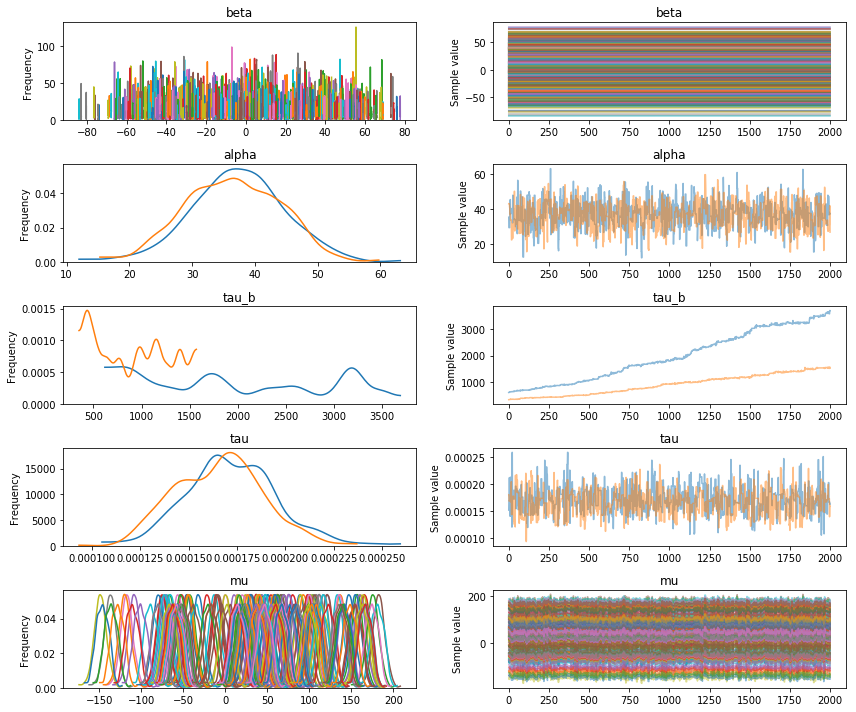

In [6]:
%matplotlib inline
pymc3.plots.traceplot(trace_c,alpha=0.5)
None

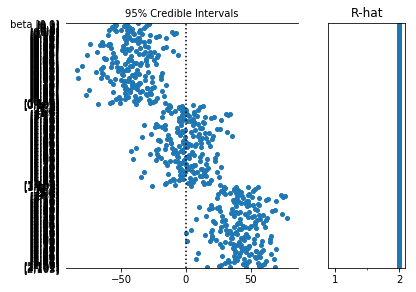

In [7]:
pymc3.forestplot(trace_c, varnames=['beta'])

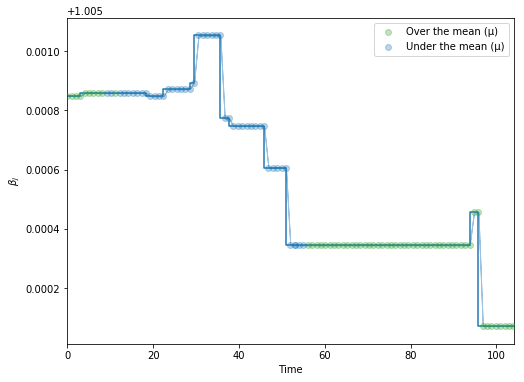

In [176]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

mercado["time"] = [i for i in range(1, N+1)]

fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]

beta___ = trace_c["beta"]
beta_ = []
for i in range(3):
    beta__ = []
    for j in range(N):
        beta__.append(beta___[:][:][j].mean())
    beta_.append(beta__)
beta_ = np.asanyarray(beta_)

beta_hpd = np.percentile(beta_, [2.5, 97.5], axis=0)
beta_low = beta_hpd[0]
beta_high = beta_hpd[1]

# interval_length = 3
interval_length = 1.019
interval_bounds = np.arange(0, mercado["time"].max() + interval_length + 1, interval_length)

last_period = np.floor((mercado["time"] - 0.01) / interval_length).astype(int)

ax.fill_between(interval_bounds[:-1], beta_low, beta_high,
                color=blue, alpha=0.45);
beta_hat = beta_.mean(axis=0)
ax.step(interval_bounds[:-1], beta_hat, color=blue);
μ_2 = mercado.SHARE.mean()
# ax.scatter(interval_bounds[last_period[(df.event.values == 1) & (df.metastized == 1)]],
#            beta_hat[last_period[(df.event.values == 1) & (df.metastized == 1)]],
#            c=red, zorder=10, label='Died, cancer metastized');
# ax.scatter(interval_bounds[last_period[(df.event.values == 0) & (df.metastized == 1)]],
#            beta_hat[last_period[(df.event.values == 0) & (df.metastized == 1)]],
#            c=blue, zorder=10, label='Censored, cancer metastized');
ax.scatter(interval_bounds[last_period[(mercado.SHARE.values >= μ_2)]],
           beta_hat[last_period[(mercado.SHARE.values >= μ_2)]],
           c=red, zorder=10, label='Over the mean (μ)', alpha=0.3);
ax.scatter(interval_bounds[last_period[(mercado.SHARE.values < μ_2)]],
           beta_hat[last_period[(mercado.SHARE.values < μ_2)]],
           c=blue, zorder=10, label='Under the mean (μ)', alpha=0.3);

ax.set_xlim(0, mercado["time"].max());
ax.set_xlabel('Time');

ax.set_ylabel(r'$\beta_j$');

ax.legend();

In [106]:
pymc3.waic(trace_c, model_c)

/home/jaa6766/.local/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=1208.1706823369848, WAIC_se=10.569950335051388, p_WAIC=7.586202003597637, var_warn=1)

In [103]:
ppc = pymc3.sample_ppc(trace_c, samples=104,  model=model_c, progressbar=False)

In [82]:
(ppc["y"])

array([[ 161.64928002,  115.35181564,   71.92912324, ...,   12.26633406,
          18.08685739,  204.93623173],
       [ 173.18729813,  163.64135444,  216.25352694, ...,  170.08029807,
         104.10571112, -101.97752232],
       [ 174.70497069,   77.39860037,  110.04055006, ...,   48.71988156,
          75.53037031,  106.80058861],
       ...,
       [ 141.2217858 ,   55.62642389,  -13.17021312, ...,  207.05927559,
         154.64349344,  185.2700609 ],
       [  35.02072929,  107.3054476 ,  -24.81805629, ...,  107.53232827,
         151.9319611 ,  -66.84792994],
       [  55.3181321 ,  208.45646809,  131.66551446, ...,  150.64133359,
          43.09433205,  170.03993124]])

In [ ]:
%matplotlib inline


In [92]:
%pwd
# pymc3.summary(trace_c)

'/home/jaa6766/Documents/jorge3a/itam/regresionavanzada2018'

In [76]:
print('Running with PyMC3 version v.{}'.format(pymc3.__version__))

Running with PyMC3 version v.3.5
